In [4]:

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from model import Generator
from config import *
from scipy.stats import truncnorm

## Load Saved Generator Model


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
generator.load_state_dict(torch.load("generator.pth", map_location=device))

<All keys matched successfully>

## Truncation Trick

In [7]:
def truncated_normal(size, threshold=1.0):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return torch.tensor(values, dtype=torch.float32)

## Generate Fake Images


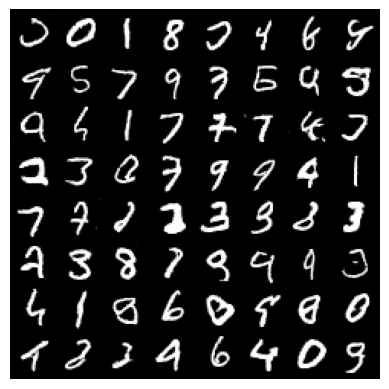

In [59]:
truncation_threshold = 0.05
latent_vectors = truncated_normal((64, LATENT_DIMENSIONS, 1, 1), threshold=truncation_threshold).to(device)

fake_samples = generator(latent_vectors)
fake_samples = fake_samples.cpu()
fake_grid = torchvision.utils.make_grid(fake_samples, padding=2, normalize=True, nrow=8)
plt.imshow(np.transpose(fake_grid, (1, 2, 0)))
plt.axis("off")
plt.show()